In [1]:
Threads.nthreads()

128

In [2]:
push!(LOAD_PATH, "./")
using Plots
using FastGaussQuadrature
using LinearAlgebra
using WriteVTK
using Bspline
using Support
using Fitting
using ElasticConstant
using Elasticity3d
using Base.Threads
using BenchmarkTools

┌ Info: Precompiling Elasticity3d [top-level]
└ @ Base loading.jl:1260


In [3]:
#### 調整できる値 ###################################################

# 物性値
la = 1.0
R_outside = 1e1*la
R_ratio = 0.0
λ = 1.0
μ = 1.0
μa = 1.0   #1.0e5*R_outside
μb = 1.0
μc = 1.0
μd = -1.0
lb = 0.0
lc = 0.0
ld = 1.0
γ_ux = 1.0e6/R_outside
γ_uxx = 1.0e-2*R_outside

dim = 3
P = [3,3,3]
N = [5,10,10]     # +numk₊,±0,-P[3]
nip = [4,4,4]
tEl = [100,60,120]
U = [0.0,0.0,0.0]
flag_periodic_condition = true
periodic_dim = [3]
flag_add_knot = true
d₊ = 1
numk₊ = 5
border = 0.999
numE₊ = 100
;
######################################################################

In [4]:
# 弾性定数
a1 = μa*la^2  # 6階テンソルA6
b1 = μb*lb^4  # 8階テンソルA8
b2 = μc*lc^2  # 6階テンソルB
b0 = μd*ld^2  # 4階テンソルD
δ,C,nonzero_C = makeδ_Classical_constant(λ,μ,dim)
A6,B,nonzero_A6,nonzero_B = makeFSG_constant(a1,b2,dim)
A8,nonzero_A8 = makeSSG_constant(b1,dim)
base4_list = make_base_list(4,dim)
base6_list = make_base_list(6,dim)
base8_list = make_base_list(8,dim)

# 初期の基底関数，リファインメント
Pi = [1,1,1]
k = [[0.0, 0.0, 1.0, 1.0],[0.0, 0.0, 1.0, 1.0],[0.0, 0.0, 1.0, 1.0]]
Ni = [length(k[1])-pi[1]-1,length(k[2])-Pi[2]-1,length(k[3])-Pi[3]-1]
pref!(Pi,P,k)
href!(P,k,N)
Nall = prod([N[d] for d in 1:dim])

# 周期性条件
if flag_periodic_condition
    periodic_condition!(P,k,N,periodic_dim)
end

# k[1]の端のノットを増やす
if flag_add_knot
    add_knot!(dim,P,k,N,Nall,d₊,numk₊,border)
    println("k[",d₊,"] = ",k[d₊])
end

k[1] = [0.0, 0.0, 0.0, 0.0, 0.5, 0.999, 0.9992, 0.9994, 0.9996, 0.9998, 1.0, 1.0, 1.0, 1.0]


In [5]:
R_outside,λ+2μ,a1,b0,γ_ux,γ_uxx

(10.0, 3.0, 1.0, -1.0, 100000.0, 0.1)

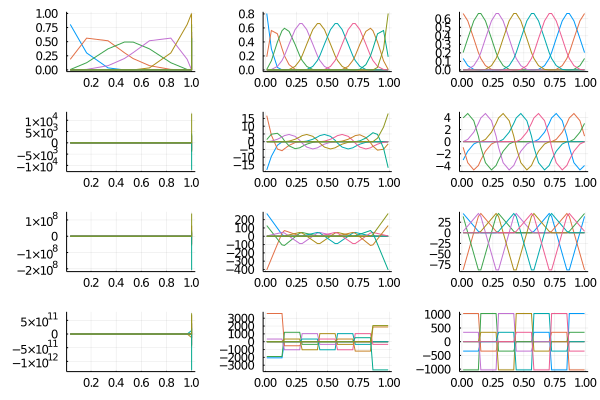

In [6]:
# Gauss積分点上のB-spline基底関数の値
tG,wG,G = make_Gauss(P,k,N,nip)
BsG,BsG_t,BsG_tt,BsG_ttt,N,Nall = make_BsG!(dim,P,k,N,Nall,periodic_dim,tG,wG,G)

plot(
    plot(tG[1],BsG[1]',legend=false),
    plot(tG[2],BsG[2]',legend=false),
    plot(tG[3],BsG[3]',legend=false),
    plot(tG[1],BsG_t[1]',legend=false),
    plot(tG[2],BsG_t[2]',legend=false),
    plot(tG[3],BsG_t[3]',legend=false),
    plot(tG[1],BsG_tt[1]',legend=false),
    plot(tG[2],BsG_tt[2]',legend=false),
    plot(tG[3],BsG_tt[3]',legend=false),
    plot(tG[1],BsG_ttt[1]',legend=false),
    plot(tG[2],BsG_ttt[2]',legend=false),
    plot(tG[3],BsG_ttt[3]',legend=false),
    layout=(4,dim)
)

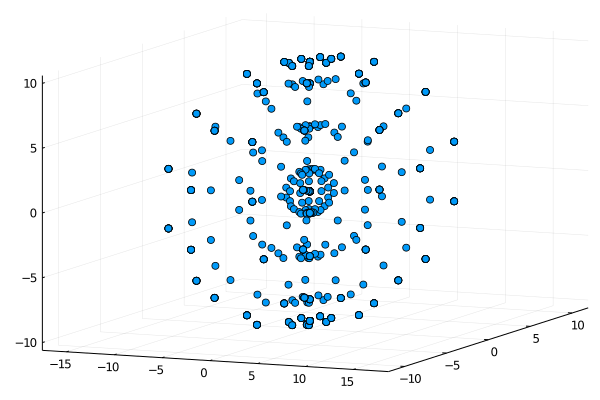

In [7]:
# 制御点のフィッティング
a = fitting_spherical_shell(dim,P,k,N,Nall,nip,tG,wG,G,BsG,R_outside,R_ratio)
a0 = deepcopy(a)

# 評価点
tE,tEl,BsE,BsE_t,BsE_tt,BsE_ttt = make_BsE!(dim,P,k,N,Nall,periodic_dim,tEl,flag_add_knot,d₊,numE₊,border)

# 初期の制御点をプロット
plot(a0[1],a0[2],a0[3],st=:scatter,legend=false,aspect_ratio=1)

In [8]:
####### 線形 ########################################################################

In [8]:
@time R = calc_R_3d(dim,P,N,Nall,nip,G,BsG)
@time R_t = calc_R_t_3d(dim,P,N,Nall,nip,G,BsG,BsG_t)
@time J,Jinv,detJ = calc_J_Jinv_detJ_3d(dim,P,N,Nall,nip,G,wG,a0,R_t)
@time J_t,Jinv_t = calc_J_t_Jinv_t_3d(dim,P,N,Nall,nip,G,wG,a0,Jinv,BsG,BsG_t,BsG_tt)
@time wG_detJ = calc_wG_detJ_3d(G,wG,detJ)
@time R_x = calc_R_x_3d(dim,P,N,Nall,nip,G,wG,R_t,Jinv)
@time x_t = calc_x_t_3d(dim,P,N,Nall,nip,G,a,R_t)
@time normal,detJsrf = calc_normal_detJsrf_3d(dim,G,x_t)
;

  0.202060 seconds (72.95 k allocations: 121.217 MiB, 47.21% gc time)
  0.148153 seconds (69.28 k allocations: 355.465 MiB, 5.32% gc time)
  0.661294 seconds (1.02 M allocations: 100.179 MiB)
  5.114428 seconds (38.15 M allocations: 5.676 GiB, 46.17% gc time)
  0.051884 seconds (45.20 k allocations: 2.517 MiB)
  0.165017 seconds (80.24 k allocations: 356.068 MiB, 26.75% gc time)
  0.017630 seconds (1.40 k allocations: 298.375 KiB)
  0.111216 seconds (92.16 k allocations: 4.795 MiB)


In [10]:
# 部分剛性行列
@time K1 = calc_K1_3d(dim,P,N,Nall,nip,G,wG_detJ,C,R_x)
@time K2 = calc_K2_3d(dim,P,N,Nall,nip,G,wG_detJ,A6,base4_list,R_t,Jinv,Jinv_t,BsG,BsG_t,BsG_tt)
;

  0.694861 seconds (406.74 k allocations: 73.650 MiB)
452.318260 seconds (435.93 k allocations: 74.930 MiB)


In [11]:
@time KP_ux = calc_KP_ux_3d(dim,P,N,Nall,nip,G,wG,detJsrf,γ_ux,δ,R_x,normal)
@time KP_uxx = calc_KP_uxx_3d(dim,P,N,Nall,nip,G,wG,detJsrf,γ_uxx,δ,normal,R_t,
                                Jinv,Jinv_t,BsG,BsG_t,BsG_tt)

K = zeros(Float64,dim*Nall,dim*Nall)
@. K = K1+K2+KP_ux#+KP_ux+KP_uxx
;
#heatmap(KP,yflip=true,color=:coolwarm)

  0.225914 seconds (412.33 k allocations: 73.960 MiB)
624.030311 seconds (953.50 M allocations: 142.091 GiB, 92.65% gc time)


UndefVarError: UndefVarError: K1 not defined

In [30]:
K1

2100×2100 Array{Float64,2}:
  2.09628       0.4027       -0.00775141   …    0.0            0.0
  0.4027        1.91245       0.00971997        0.0            0.0
 -0.00775141    0.00971997    1.00598           0.0            0.0
 -0.114389     -0.170863     -0.0055728         0.0            0.0
 -0.170863     -0.386906      0.00268372        0.0            0.0
 -0.0055728     0.00268372   -0.123453     …    0.0            0.0
 -0.312362      4.29906e-15  -0.000637561       0.0            0.0
  4.29906e-15  -0.762454     -3.80348e-17       0.0            0.0
 -0.000637561  -3.80348e-17  -0.268516          0.0            0.0
 -0.016027      0.00831257   -4.93656e-6        0.0            0.0
  0.00831257   -0.0292851    -2.37732e-6   …    0.0            0.0
 -4.93656e-6   -2.37732e-6   -0.0113264         0.0            0.0
 -0.0250219     0.0103656     3.41621e-6        0.0            0.0
  ⋮                                        ⋱                 
  0.0           0.0           0.0      

In [31]:
K2

2100×2100 Array{Float64,2}:
 28120.2            7675.4          …       0.0              0.0
  7675.4           24616.4                  0.0              0.0
   -15.1813           19.0368               0.0              0.0
 -8259.1           -4013.33                 0.0              0.0
 -4013.33         -14660.1                  0.0              0.0
    -3.14905           1.5165       …       0.0              0.0
 -1656.95              6.41475e-11          0.0              0.0
     6.41475e-11   -3540.2                  0.0              0.0
     3.35002          -4.30762e-12          0.0              0.0
   621.93           -465.872                0.0              0.0
  -465.872          1364.97         …       0.0              0.0
     0.149817          0.0721479            0.0              0.0
  1126.04           -580.932                0.0              0.0
     ⋮                              ⋱                   
     0.0               0.0                  1.40551e-8    7404.52
    

In [32]:
KP_ux

2100×2100 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 ⋮                        ⋮         ⋱                          
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [33]:
KP_uxx

2100×2100 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0         0.0         0.0
 ⋮                        ⋮         ⋱                          
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [34]:
#range_show = dim*Nall*0.7,dim*Nall
#heatmap(KP_ux,yflip=true,color=:coolwarm,xlims=range_show,ylims=range_show)

In [35]:
#range_show = dim*Nall*0.7,dim*Nall
#heatmap(KP_uxx,yflip=true,color=:coolwarm,xlims=range_show,ylims=range_show)

In [11]:
# 右辺ベクトル，境界条件，連立方程式
s = calc_rhs_surface_energy_3d(dim,P,N,Nall,nip,wG,G,detJsrf,b0,normal,R_t,Jinv,Jinv_t,BsG,BsG_t,BsG_tt)
#s = calc_rhs_hydrostatic_pressure_3d(dim,P,N,Nall,nip,wG,G,detJsrf,normal,BsG)

# # Dirichlet境界条件
# range_fix = dim*N[2]*N[3]
# K[1:range_fix,:] .= 0.0
# K[:,1:range_fix] .= 0.0
# for idx in 1:range_fix
#     K[idx,idx] = 1.0
# end
# for idx in 1:range_fix
#     I,i = div_idx(dim,idx)
#     s[idx] = U[i]
# end
# for idx in range_fix:dim*Nall
#     I,i = div_idx(dim,idx)
#     s[idx] -= K[idx,1]*U[i]
# end

# # 連立方程式を解く
# ucv = zeros(Float64,dim*Nall)
# uc = [zeros(Float64,Nall) for d in 1:dim]
# ucv = K\s
# for idx in 1:dim*Nall
#     I,i = div_idx(dim,idx)
#     uc[i][I] = ucv[idx]
# end

# 両端Neumann
# Dirichlet境界条件
range_fix = dim*N[2]*N[3]-dim+1:dim*N[2]*N[3]+dim
K[range_fix,:] .= 0.0
K[:,range_fix] .= 0.0
for idx in range_fix
    K[idx,idx] = 1.0
end
for idx in range_fix
    I,i = div_idx(dim,idx)
    s[idx] = U[i]
end
for idx in 1:dim*N[2]*N[3]-dim
    I,i = div_idx(dim,idx)
    s[idx] -= K[idx,1]*U[i]
end
for idx in dim*N[2]*N[3]+dim+1:dim*Nall
    I,i = div_idx(dim,idx)
    s[idx] -= K[idx,1]*U[i]
end

# 連立方程式を解く
ucv = zeros(Float64,dim*Nall)
uc = [zeros(Float64,Nall) for d in 1:dim]
ucv = K\s
for idx in 1:dim*Nall
    I,i = div_idx(dim,idx)
    uc[i][I] = ucv[idx]
end

UndefVarError: UndefVarError: K not defined

In [37]:
eigvals(K)

2100-element Array{Float64,1}:
 -5.964706647784429e-5
  2.2057086290997516e-5
  4.45065927469946e-5
  0.04368949739894207
  0.04378664000993439
  0.04747438570188472
  0.047490885149187666
  0.056620833150367735
  0.05668049410490046
  0.05674933002415049
  0.0568415039165461
  0.06744933355785515
  0.06746412878770863
  ⋮
  1.3716945473030332e13
  1.3716945473065389e13
  1.3717689344298629e13
  1.5906152271994137e13
  1.591772934325478e13
  1.5917729356984426e13
  1.5942376990269697e13
  1.5942376990280225e13
  1.5978827741037418e13
  2.085968926660118e13
  2.089216890516125e13
  2.089216890529471e13

In [32]:
# 変位を表示する
XE,uE_lin = calc_XE_uE_3d(dim,P,k,N,tE,tEl,BsE,a0,uc)
unG_lin = calc_unG_3d(dim,P,k,N,G,a0,uc,R,R_x,R_xx,normal)
XG,uG_lin,u_xG_lin,u_xxG_lin = calc_XG_uG_3d(dim,P,k,N,G,a0,uc,R,R_x,R_xx)
plot(XE[1,:,div(tEl[2],2),1],uE_lin[1,:,div(tEl[2],2),1],legend=false,xlabel="x",ylabel="u")

UndefVarError: UndefVarError: uc not defined

In [25]:
uE_lin[1,end,div(tEl[2],2),1]

UndefVarError: UndefVarError: uE_lin not defined

In [26]:
plot(XG[1,:,1,1],unG_lin[:,1,1],legend=false,xlabel="x",ylabel="u")

UndefVarError: UndefVarError: XG not defined

In [27]:
plot(XG[1,:,div(G[2],2),1],u_xG_lin[1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_x")

UndefVarError: UndefVarError: XG not defined

In [28]:
plot(XG[1,:,div(G[2],2),1],u_xxG_lin[1,1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_xx")

UndefVarError: UndefVarError: XG not defined

In [29]:
plot(XE[1,:,div(tEl[2],2),1],uE_lin[1,:,div(tEl[2],2),1],legend=false,xlabel="x",ylabel="u",
    xlims=(R_outside*0.995,R_outside))

UndefVarError: UndefVarError: XE not defined

In [30]:
plot(XG[1,:,div(G[2],2),1],u_xG_lin[1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_x",
    xlims=(R_outside*0.99,R_outside))

UndefVarError: UndefVarError: XG not defined

In [31]:
plot(XG[1,:,div(G[2],2),1],u_xxG_lin[1,1,1,:,div(G[2],2),1],legend=false,xlabel="x",ylabel="u_xx",
    xlims=(R_outside*0.99,R_outside))

UndefVarError: UndefVarError: XG not defined

In [32]:
# vtkファイルを作成
vtkfile = vtk_grid("sphere_hyoumenkouka_linear",XE)
vtk_point_data(vtkfile, uE_lin, "displacement")
outfiles = vtk_save(vtkfile)

UndefVarError: UndefVarError: XE not defined

In [33]:
aview = zeros(Float64,dim,N[1],N[2],N[3])
for d in 1:dim
    for I in 1:Nall
        I1 = div(div(I-1,N[3]),N[2])+1
        I2 = div(I-1,N[3])%N[2]+1
        I3 = (I-1)%N[3]+1
        
        aview[d,I1,I2,I3] = a[d][I]
    end
end

In [34]:
vtkfile = vtk_grid("sphere_seigyoten", aview)
outfiles = vtk_save(vtkfile)

1-element Array{String,1}:
 "sphere_seigyoten.vts"

In [80]:
### 非線形 ##########################################################

In [79]:
uc

3-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0008106492771871056, 0.0008089874252480784, -0.0026058824344441685, -0.0038549261313621476, -0.002606121224341789, 0.00040804943561882694, 0.0034236939103273914, 0.004672033332838133, 0.0034243738328411837, 0.0004089810470080532]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.0005710785048389454, -0.00024594007705469416, 0.002600598558198014, -0.00041360584572111347, -0.0034284827109394875, -0.004677333411385402, -0.0034292321583189707, -0.0004139844124097357, 0.002599814078510957, 0.00385002707941125]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.0023097365137181567, -0.002189393382881379, 0.001711021523003504, 0.0017102798918907556, 0.0017110490346930968, 0.0017098706392013356, 0.0017106559536970406, 0.0017099623039801243, 0.0017104583589032097, 0.0017104770355573506]

In [133]:
# 線形解をニュートン法の初期値にする
for i in 1:dim
    for I in 1:Nall   
        a[i][I] += uc[i][I]
    end
end

In [82]:
s = calc_rhs_hydrostatic_pressure(dim,P,N,Nall,nip,wG,G,detJ,normal,BsG)
;

In [26]:
# 反復式
F = zeros(Float64,dim*Nall)
H = zeros(Float64,dim*Nall,dim*Nall)
Δa = zeros(Float64,dim*Nall)
@time for ν in 1:7
    Q2 = calc_Q2_3d(dim,P,N,Nall,nip,G,a,R_x)
    Q3 = calc_Q3_3d(dim,P,N,Nall,nip,G,a,R_t,Jinv,Jinv_t,BsG,BsG_t,BsG_tt)
    x_t = calc_x_t_3d(dim,P,N,Nall,nip,G,a,R_t)
    normal = calc_normal_3d(dim,G,x_t)
    
    F1 = calc_F1_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,C,nonzero_C,base4_list,R_x,Q2)
    H1 = calc_H1_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,C,nonzero_C,base4_list,R_x,Q2)
    F2 = calc_F2_3d(dim,P,N,Nall,nip,G,wG_detJ,A6,nonzero_A6,base6_list,R_x,Q2,Q3,
                        R_t,Jinv,Jinv_t,BsG,BsG_t,BsG_tt)
    H2 = calc_H2_3d(dim,P,N,Nall,nip,G,wG_detJ,δ,A6,nonzero_A6,base6_list,R_x,Q2,Q3,
                        R_t,Jinv,Jinv_t,BsG,BsG_t,BsG_tt)
    F5 = calc_F5_3d(dim,P,N,Nall,nip,G,wG,b0,detJ,R_x,Q2,Q3,normal,R_t,Jinv,Jinv_t,BsG,BsG_t,BsG_tt)
    H5 = calc_H5_3d(dim,P,N,Nall,nip,G,wG,δ,b0,detJ,R_x,normal,R_t,Jinv,Jinv_t,BsG,BsG_t,BsG_tt)
        
    #F = F1-s
    #H = H1
    
    @. F = F1+F2+F5
    @. H = H1+H2+H5
    
    # Dirichlet境界条件
    range_fix = dim*N[2]*N[3]-dim+1:dim*N[2]*N[3]+dim
    H[range_fix,:] .= 0.0
    H[:,range_fix] .= 0.0
    for idx in range_fix
        H[idx,idx] = 1.0
    end
    F[range_fix] .= 0.0
    
    Δa = H\(-F)
    
    # aを更新
    for i in 1:dim
        for I in 1:Nall
            idx = (I-1)*dim+i
            a[i][I] += Δa[idx]
        end
    end
    
    # 収束判定
    Fnorm = sqrt(sum(F[idx]^2 for idx in 1:dim*Nall))
    anorm = sqrt(sum(Δa[idx]^2 for idx in 1:dim*Nall))
    println("ν=",ν,": Fnorm=",Fnorm,", anorm=",anorm)
    if anorm<1.0e-6
        break
    end
end

ν=1: Fnorm=4.83549016604131e6, anorm=2.7626365640073387
ν=2: Fnorm=102171.16752658873, anorm=0.5516154931979114
ν=3: Fnorm=238.9194122337178, anorm=0.016573655248350593
ν=4: Fnorm=0.18513257081880433, anorm=0.0005393764474246893
ν=5: Fnorm=0.00016054704510862076, anorm=4.6971684959901205e-5
ν=6: Fnorm=0.0001998553273387378, anorm=2.46314025532324e-5
ν=7: Fnorm=0.00027463027954984377, anorm=1.864194966909292e-5
2024.478853 seconds (11.17 M allocations: 3.109 GiB, 0.20% gc time)


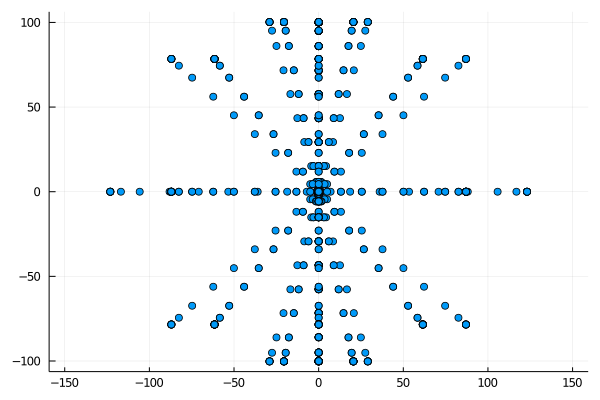

In [27]:
plot(a[1],a[3], st=:scatter,legend=false,aspect_ratio=1)

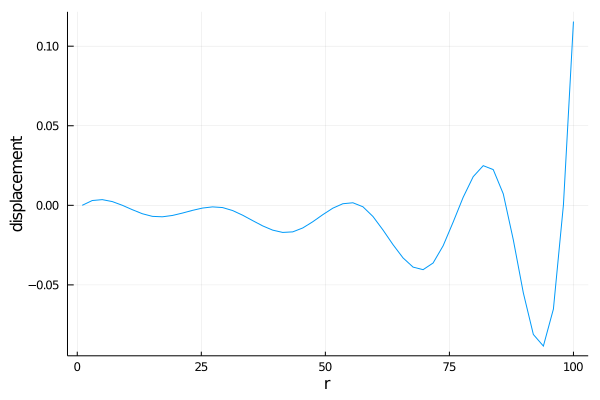

In [28]:
# 変位を表示する
x_length = collect(range(R_outside*R_ratio,R_outside,length=tEl[1]))
u_nonlinear = zeros(Float64,3,tEl[1],tEl[2],tEl[3])
x = calc_x_or_u_Evaluation(dim,P,k,N,tE,tEl,BsE,a)
u_nonlinear = x-x0
plot(x_length,u_nonlinear[1,:,div(tEl[2],2),1],legend=false,xlabel="r",ylabel="displacement")

In [29]:
u_nonlinear[1,tEl[1],div(tEl[2],2),1]/R_outside

0.0011548424638463928

In [30]:
# vtkファイルを作成
vtkfile = vtk_grid("sphere_hyoumenkouka_nonlinear", x0)
vtk_point_data(vtkfile, u_nonlinear, "displacement")
outfiles = vtk_save(vtkfile)

1-element Array{String,1}:
 "sphere_hyoumenkouka_nonlinear.vts"

In [31]:
# # 第2Piola-Kirchhoff応力(積分点上に値をとる)
# S = zeros(2,2,G1,G2,1)
# for nG1 in 1:G1
#     for nG2 in 1:G2
#         for i in 1:2
#             for j in 1:2
#                 for k in 1:2
#                     for l in 1:2
#                         tmp = sum(Q2[m,k,nG1,nG2]*Q2[m,l,nG1,nG2] for m in 1:2)
#                         S[i,j,nG1,nG2,1] += 1/2*C[i,j,k,l]*(tmp-δ[k,l])
#                     end
#                 end
#             end
#         end
#     end
# end

# # vtkファイルを作成
# # 第2Piola-Kirchhoff応力
# vtkfile = vtk_grid("2d_enkan_hyoumenkouka_hisenkei_kotenkou", x0) # 参考状態
# vtk_point_data(vtkfile, S[1,1,:,:,:], "S11")
# vtk_point_data(vtkfile, S[1,2,:,:,:], "S12")
# vtk_point_data(vtkfile, S[2,1,:,:,:], "S21")
# vtk_point_data(vtkfile, S[2,2,:,:,:], "S22")
# outfiles = vtk_save(vtkfile)

In [126]:
u_linear[1,tEl[1],div(tEl[2],2),1]/R_outside

-0.00026339573994870277

In [75]:
1

1

In [76]:
@code_warntype
Threads.@threads
heatmap(,yflip=true,color=:coolwarm)

LoadError: BoundsError: attempt to access ()
  at index [0]

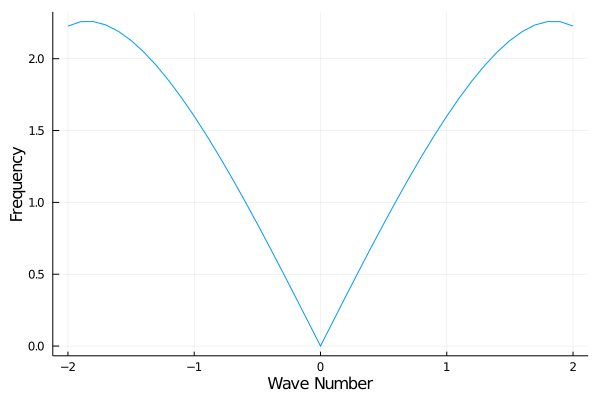

In [9]:
# フォノンの分散関係
num_k_wave = 4
k_wave = [i for i in -div(num_k_wave,2):0.1:div(num_k_wave,2)]
function dispesion_relation_SSG(k_wave,λ,μ,a1,b1,b2)
    return sqrt( (λ+2μ)*k_wave^2 + (a1-b2)*k_wave^4 + b1*k_wave^6 )
end
plot(k_wave,dispesion_relation_SSG.(k_wave,λ,μ,a1,b1,b2),xlabel="Wave Number",ylabel="Frequency",
    legend=false)

In [38]:
a1-b2,b1

(10.0, 0.0)

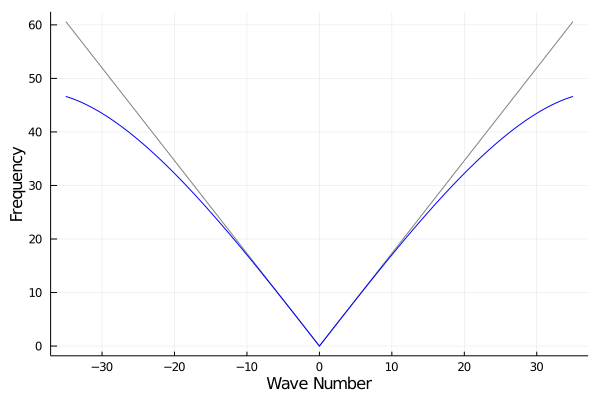

In [59]:
num_k_wave = 70
k_wave = [i for i in -div(num_k_wave,2):0.1:div(num_k_wave,2)]
function dispesion_relation_classical(k_wave,λ,μ,a1,b1,b2)
    return sqrt( (λ+2μ)*k_wave^2)
end
function dispesion_relation_SSG(k_wave,λ,μ,a1,b1,b2)
    return sqrt( (λ+2μ)*k_wave^2 -0.001*k_wave^4)
end

plot(k_wave,dispesion_relation_classical.(k_wave,λ,μ,a1,b1,b2),xlabel="Wave Number",ylabel="Frequency",
    legend=false,color="gray")
plot!(k_wave,dispesion_relation_SSG.(k_wave,λ,μ,a1,b1,b2),xlabel="Wave Number",ylabel="Frequency",
    legend=false,color="blue")

In [ ]:
# 構造体
# mutable struct IGA
#     dim::Int64
#     P::Array{Int64,1}
#     k::Array{Array{Float64,1},1}
#     N::Array{Int64,1}
#     Nall::Int64
#     nip::Array{Int64,1}
#     G::Array{Int64,1}
#     wG::Array{Array{Float64,1},1}
#     BsG::Array{Array{Float64,2},1}
#     BsG_t::Array{Array{Float64,2},1}
#     BsG_tt::Array{Array{Float64,2},1}
#     BsG_ttt::Array{Array{Float64,2},1}
#     function IGA(dim,P,k,N,Nall,nip,G,wG,BsG,BsG_t,BsG_tt,BsG_ttt)
#         return new(dim,P,k,N,Nall,nip,G,wG,BsG,BsG_t,BsG_tt,BsG_ttt)
#     end
# end
# iga = IGA(dim,P,k,N,Nall,nip,G,wG,BsG,BsG_t,BsG_tt,BsG_ttt)